In [11]:
import torch, json
import numpy as np
from torchvision import datasets, models, transforms
from PIL import Image
import torchvision, time, os, copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import sys
import matplotlib.pyplot as plt
import model_factory
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224), # ImageNet models were trained on 224x224 images
        #transforms.RandomHorizontalFlip(), # flip horizontally 50% of the time - increases train set variability
        transforms.ToTensor(), # convert it to a PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet models expect this norm
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'gps_lock_v5'
# Create train and validation datasets and loaders
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

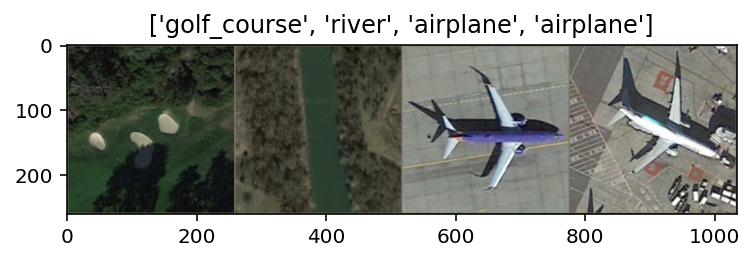

In [12]:
# Helper function for displaying images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Un-normalize the images
    inp = std * inp + mean
    # Clip just in case
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_time = [] # we'll keep track of the time needed for each epoch
    training_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss.append(epoch_loss)
            if phase =='train':
                training_loss.append(epoch_loss)
        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    plt.plot(training_loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    plt.savefig('output_stat.png')
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time

In [ ]:
# Download a pre-trained ResNet50 model and freeze its weights
model = torchvision.models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model
# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs, 10)
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 10),
                                 nn.LogSoftmax(dim=1))
# Send the model to the GPU
model = model.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.Adam(model.fc.parameters(), lr=0.0001)
#optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model, epoch_time = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)
PATH = "best_checkpoint_resnet50.pth.tar"
#torch.save(model.state_dict(), PATH)
#orch.save({'model_state_dict': model.state_dict()}, PATH)
torch.save(model, PATH)

Epoch 1/5
----------
train Loss: 0.8791 Acc: 0.7466
val Loss: 0.0491 Acc: 0.9925

Epoch 2/5
----------
train Loss: 0.2928 Acc: 0.9173
val Loss: 0.0206 Acc: 0.9950

Epoch 3/5
----------


arg :  [tensor(5, device='cuda:0')]
labels :  ['airplane', 'beach', 'forest', 'golf_course', 'parking_lot', 'river', 'shipping_yard', 'solar_panel', 'swimming_pool', 'tennis_court']
Predicted class is: river


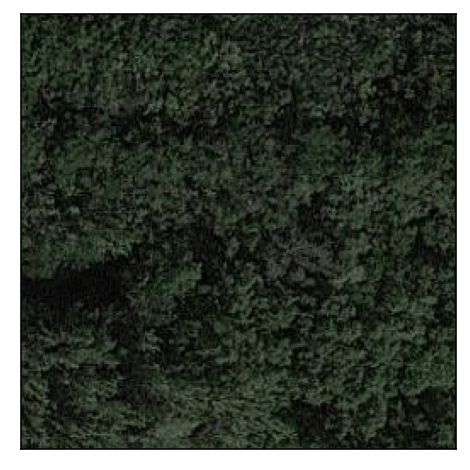

In [10]:
import sys
#sys.path.insert(0, '/home/mircea/python-envs/env/lib/python3.6/site-packages/vision')

# Choose an image to pass through the model
test_image = '/media/ajithbalakrishnan/external/Dataset/Pytorch_classification/Pytorch_Classifier_Training_Pipeline/gps_lock_v5/val/forest/forest040.jpg'
checkpoint = "best_checkpoint_resnet50.pth.tar" 

import torch, json
import numpy as np
import torchvision, time, os, copy
from torchvision import datasets, models, transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torch, json
import numpy as np
from torchvision import datasets, models, transforms
from PIL import Image
import model_factory

# Import matplotlib and configure it for pretty inline plots
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Prepare the labels

labels = ["airplane","beach","forest","golf_course","parking_lot","river","shipping_yard","solar_panel","swimming_pool","tennis_court"]

# First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
# Load the image
image = Image.open(test_image)
plt.imshow(image), plt.xticks([]), plt.yticks([])

# Now apply the transformation, expand the batch dimension, and send the image to the GPU
image = data_transform(image).unsqueeze(0).cuda()

# Download the model if it's not there already. It will take a bit on the first run, after that it's fast
#model = torchvision.models.resnet50()
#checkpoint_loaded = torch.load(checkpoint)
#model.load_state_dict(checkpoint_loaded['model_state_dict'])

model = torch.load(PATH)

# Send the model to the GPU 
model.cuda()
# Set layers such as dropout and batchnorm in evaluation mode
model.eval()

out = model(image)
# Find the predicted class
print("arg : ",str([out.argmax()]))
print("labels : ",labels)
print("Predicted class is: {}".format(labels[out.argmax()]))